In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [3]:
csv_path = 'Data/EvacuationTimeTest.csv'

# Import the CSV
data = pd.read_csv(csv_path)

The evacuation time for a vacuum pump can be calculated as:
t = V / q ln(p0 / p1)

t: time (s)

V: Volume (m^3)

q: pump speed (m^3/s)

p0: initial pressure

p1: final pressure

rearranging:
p1 = p0*exp(-t*q/V)

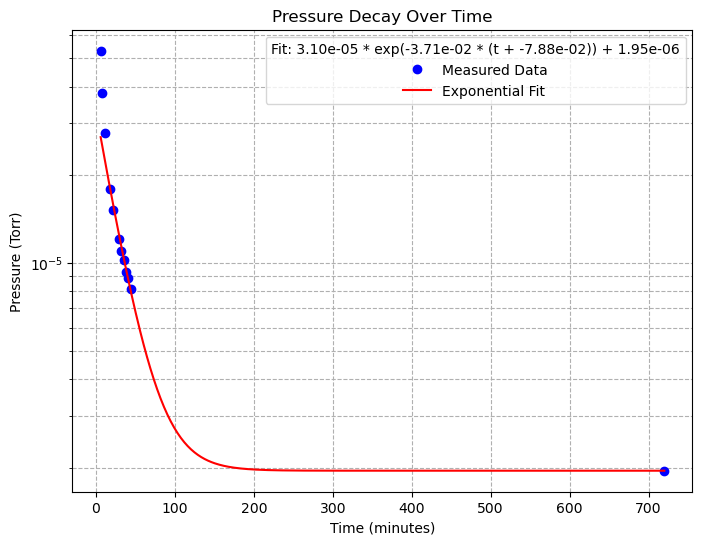

Fitted parameters:
A = 3.1029e-05
B = 3.7103e-02
C = -7.8822e-02
C = 1.9503e-06
Estimated time to reach 3.0e-06 Torr: 91.35 minutes


In [4]:
# === Define the exponential decay function ===
def exp_decay(t, A, B, C, D):
    return A * np.exp(-B * (t+C)) + D

# === Function to estimate evacuation time ===
def estimate_time_for_pressure(target_pressure, A, B, C, D):
    """
    Estimate the time required to reach a specified pressure using the fitted exponential decay model.
    """
    if target_pressure <= D:
        print("Target pressure is below the asymptotic pressure C. Cannot estimate time.")
        return None
    if (target_pressure - D) / A <= 0:
        print("Invalid target pressure. Ensure it's between the initial and asymptotic pressures.")
        return None
    t = -np.log((target_pressure - D) / A) / B - C
    return t

# === Prepare the data (skip first 5 entries) ===
data_after_5 = data.iloc[10:]
time = data_after_5.iloc[:, 0].values
pressure = data_after_5.iloc[:, 1].values

# === Plot the raw data ===
plt.figure(figsize=(8,6))
plt.semilogy(time, pressure, 'bo', label='Measured Data')  # blue dots
plt.xlabel('Time (minutes)')
plt.ylabel('Pressure (Torr)')
plt.title('Pressure Decay Over Time')
plt.grid(True, which="both", ls="--")

# === Set up initial guess and weights ===
p0 = [pressure[0] - pressure[-1], 0.01, pressure[-1], pressure[-1]]  # (A, B, C) initial guess
sigma = pressure**2

# === Curve fitting ===
popt, pcov = curve_fit(exp_decay, time, pressure, p0=p0, sigma=sigma, absolute_sigma=False, maxfev=1000000)
A_fit, B_fit, C_fit, D_fit = popt

# === Overlay the fitted curve ===
time_fit = np.linspace(time.min(), time.max(), 500)
pressure_fit = exp_decay(time_fit, A_fit, B_fit, C_fit, D_fit)
plt.semilogy(time_fit, pressure_fit, 'r-', label='Exponential Fit')

# === Annotate the fit ===
fit_eq = f'{A_fit:.2e} * exp(-{B_fit:.2e} * (t + {C_fit:.2e})) + {D_fit:.2e}'
plt.legend(title=f'Fit: {fit_eq}')

plt.show()

# === Print fitted parameters ===
print('Fitted parameters:')
print(f'A = {A_fit:.4e}')
print(f'B = {B_fit:.4e}')
print(f'C = {C_fit:.4e}')
print(f'C = {D_fit:.4e}')

# === Estimate evacuation time for a given target pressure ===
target_pressure = 3e-6  # Example target pressure (Torr)
estimated_time = estimate_time_for_pressure(target_pressure, A_fit, B_fit, C_fit, D_fit)
if estimated_time is not None:
    print(f"Estimated time to reach {target_pressure:.1e} Torr: {estimated_time:.2f} minutes")

Now assuming V is x times larger than in test case:

In [10]:
V_ratio = 100
A_adjusted = A_fit * V_ratio
estimated_time_largeV = estimate_time_for_pressure(target_pressure, A_adjusted, B_fit, C_fit, D_fit)
if estimated_time is not None:
    print(f"Estimated time to reach {target_pressure:.1e} Torr: {estimated_time_largeV:.2f} minutes")

Estimated time to reach 3.0e-06 Torr: 215.46 minutes
